In [1]:
import math 
import pandas as pd 
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import Sequential
from scipy import stats as ss
from tensorflow.keras.layers.experimental import preprocessing as pp
import numpy as np
import kaggle
from sklearn.model_selection import train_test_split

# Kaggle URL
https://www.kaggle.com/

In [2]:
data = pd.read_csv('../kaggle_datasets/heart_2020_cleaned.csv')

In [3]:
data.HeartDisease.value_counts().loc['Yes']

27373

In [4]:
no_data = data[data.HeartDisease=='No'].sample(data.HeartDisease.value_counts().loc['Yes'], random_state=10)
yes_data = data[data.HeartDisease=='Yes']
data = pd.concat([no_data, yes_data])

In [5]:
from sklearn.utils import shuffle
data = shuffle(data)

In [6]:
label = data.pop('HeartDisease')
label = label.replace({'No':0, 'Yes':1}).astype('int32')

In [7]:
categorical_cols = ['Smoking', 
                    'AlcoholDrinking', 
                    'Stroke',
                    'PhysicalHealth', # check description
                    'MentalHealth', # check description
                    'DiffWalking', 
                    'Sex', 
                    'AgeCategory',
                    'Race', 
                    'Diabetic', 
                    'PhysicalActivity', 
                    'GenHealth', 
                    'Asthma', 
                    'KidneyDisease', 
                    'SkinCancer']

In [8]:
numerical_cols = [i for i in data.columns if i not in categorical_cols]

In [9]:
from collections import Counter
def conditional_entropy(x,y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurances = sum(y_counter.values())
    
    entropy = 0.0
    for xy in xy_counter.keys():
        p_y = y_counter[xy[1]]/total_occurances
        p_xy = xy_counter[xy]/total_occurances
        entropy += p_xy * math.log(p_y/ p_xy, math.e)
    return entropy

In [10]:
def theils_u(x,y):
    # formula = (H(X)-H(X|Y))/H(X)
    h_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurances = sum(x_counter.values())
    p_x = list(map(lambda x: x/total_occurances, x_counter.values()))
    h_x = ss.entropy(p_x)
    
    if h_x == 0:
        coeff = 1
    else: 
        coeff = (h_x - h_xy)/h_x
    return coeff

In [11]:
def data_cleanup(df):
    '''
    df: pandas dataframe
    '''
    if type(df)!=pd.core.frame.DataFrame:
        raise ValueError('input is not a pandas dataframe')
    working_df = df.copy()
    cols = working_df.columns
    converted_columns = {}
    for col in cols:
        if working_df[col].dtype == 'O':
            unique_values = working_df[col].unique()
            converted_values = {v:k for k,v in enumerate(unique_values)}
            for value in unique_values:
                working_df[col] = working_df[col].replace(value, converted_values[value])
            converted_columns[col] = converted_values
    return working_df, converted_columns

In [12]:
working_df, index = data_cleanup(data)

In [13]:
d_cat = {}
for header in categorical_cols:
    d_cat[header]= theils_u(data[header], label)

print([k for k,v in d_cat.items() if v>0.05])
sorted(d_cat.items(), key=lambda v: v[1], reverse=True)

['Stroke', 'DiffWalking', 'Diabetic', 'GenHealth', 'KidneyDisease']


[('Stroke', 0.09456438843020078),
 ('DiffWalking', 0.07879816141422262),
 ('KidneyDisease', 0.06770803830165954),
 ('Diabetic', 0.055993038599269684),
 ('GenHealth', 0.054873599367601604),
 ('AgeCategory', 0.04493785864301034),
 ('Smoking', 0.02669830073941945),
 ('SkinCancer', 0.02633347738212963),
 ('PhysicalActivity', 0.022200304438007842),
 ('PhysicalHealth', 0.02125260029417571),
 ('Sex', 0.010420778239845939),
 ('AlcoholDrinking', 0.009525805809697517),
 ('Race', 0.006705251598493517),
 ('Asthma', 0.004781783698799134),
 ('MentalHealth', 0.0030829856050773596)]

In [14]:
d_num = {}
for header in numerical_cols:
    d_num[header] = ss.pointbiserialr(data[header].astype('int32'), label).correlation

sorted(d_num.items(), key=lambda v: v[1], reverse=True)

[('BMI', 0.08917608863174388), ('SleepTime', 0.01683205855584008)]

In [15]:
filtered_cat_cols = [k for k,v in d_cat.items() if v>0.05]
filtered_num_cols = [k for k,v in d_num.items() if v>0.05]

In [16]:
def get_categorical_encoding_layer(feature, dataset, dtype, max_tokens):
    index = pp.IntegerLookup(max_values=max_tokens, oov_value=-2) # integer lookup initialization 
    feature_ds = dataset.map(lambda x,y: x[feature]) # slice dataset to get the feature column
    index.adapt(feature_ds) # analyze the feature column to generate a vocabulary 
    encoder = pp.CategoryEncoding(max_tokens=len(index.get_vocabulary())) # generate an encoding layer 
    return lambda feature: encoder(index(feature)) #returns a encoder which takes feature as argument

def get_normalization_layer(feature, dataset):
    normalizer = pp.Normalization(axis=None)
    feature_ds = dataset.map(lambda x,y: x[feature])
    normalizer.adapt(feature_ds)
    return normalizer

In [17]:
def dataset_from_dataframe(df, label, batch_size=32):
    ds = df.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(ds), label))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [18]:
ds = working_df[filtered_cat_cols+filtered_num_cols]

In [19]:
train, test, train_label, test_label = train_test_split(ds, label, test_size=0.2)
train, val, train_label, val_label = train_test_split(train, train_label, test_size=0.2)

train_ds = dataset_from_dataframe(train, train_label)
val_ds = dataset_from_dataframe(val, val_label)
test_ds = dataset_from_dataframe(test, test_label)

In [20]:
all_inputs = []
encoded_inputs = []

for header in filtered_cat_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
    encoding_layer = get_categorical_encoding_layer(feature=header, 
                                              dataset=train_ds,
                                              dtype='int32',
                                              max_tokens=5 #random_number do optimize
                                             )
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_inputs.append(encoded_categorical_col)
    
for header in filtered_num_cols:
    numerical_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(feature=header, 
                                                  dataset=train_ds
                                                 )
    normalized_numerical_layer = normalization_layer(numerical_col)
    all_inputs.append(numerical_col)
    encoded_inputs.append(normalized_numerical_layer)
    

In [21]:
all_features = tf.keras.layers.concatenate(encoded_inputs)

x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

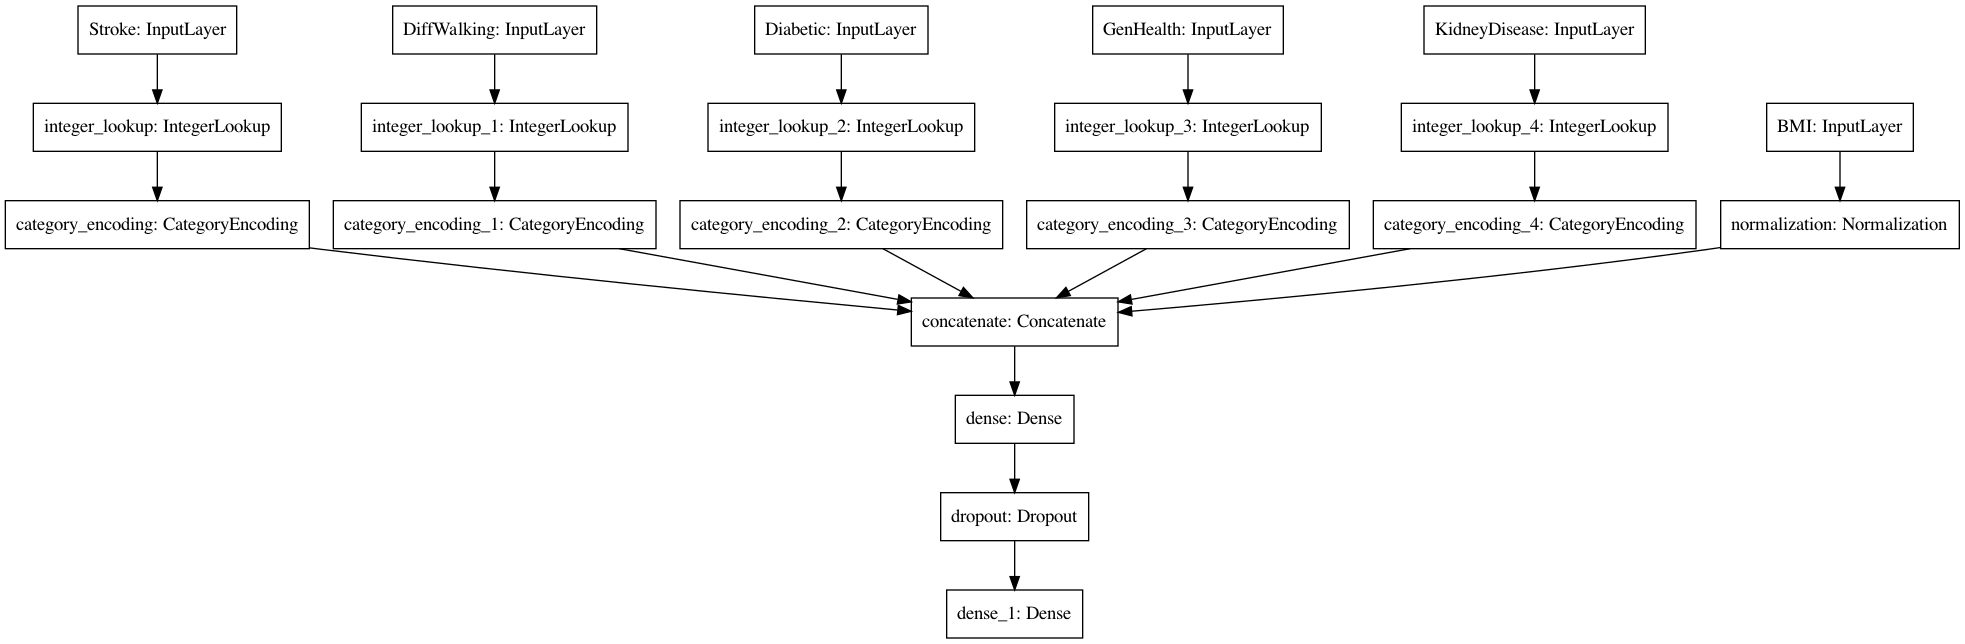

In [22]:
tf.keras.utils.plot_model(model)

In [23]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=20,
                    verbose=True)

Epoch 1/20
1095/1095 [==============================] - 3s 2ms/step - loss: 0.6276 - accuracy: 0.6166 - val_loss: 0.5740 - val_accuracy: 0.6672
Epoch 2/20
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5829 - accuracy: 0.6811 - val_loss: 0.5717 - val_accuracy: 0.6710
Epoch 3/20
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5812 - accuracy: 0.6765 - val_loss: 0.5705 - val_accuracy: 0.6734
Epoch 4/20
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5785 - accuracy: 0.6778 - val_loss: 0.5700 - val_accuracy: 0.6710
Epoch 5/20
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5773 - accuracy: 0.6791 - val_loss: 0.5696 - val_accuracy: 0.6733
Epoch 6/20
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5784 - accuracy: 0.6768 - val_loss: 0.5697 - val_accuracy: 0.6751
Epoch 7/20
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5777 - accuracy: 0.6766 - val_loss: 0.5697 - val_accuracy:

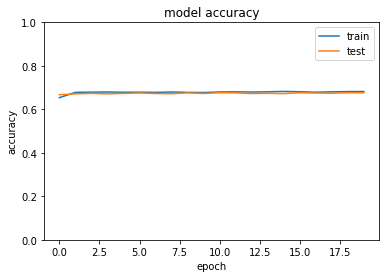

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,1)
plt.show()


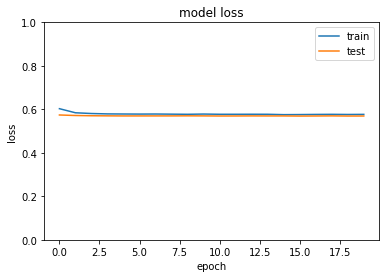

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,1)
plt.show()

In [27]:
# evaluation on test data
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

343/343 [==============================] - 0s 712us/step - loss: 0.5710 - accuracy: 0.6768
Accuracy 0.6768036484718323


In [28]:
data

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
155070,23.49,Yes,No,No,2.0,0.0,No,Female,70-74,White,No,Yes,Fair,7.0,No,Yes,Yes
187033,27.41,No,No,No,0.0,0.0,No,Male,65-69,White,No,Yes,Excellent,8.0,No,No,No
215564,25.40,Yes,No,No,0.0,0.0,No,Male,75-79,White,No,Yes,Excellent,6.0,No,No,No
131421,36.59,No,No,No,1.0,0.0,No,Male,70-74,White,No,Yes,Excellent,8.0,No,No,No
17854,28.89,No,No,Yes,30.0,30.0,Yes,Female,65-69,American Indian/Alaskan Native,No,No,Poor,6.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275768,31.46,Yes,No,No,0.0,10.0,No,Male,65-69,White,Yes,No,Fair,8.0,No,No,No
68242,29.99,Yes,Yes,No,0.0,2.0,No,Male,60-64,White,No,Yes,Very good,7.0,No,No,Yes
277990,26.57,No,No,No,14.0,0.0,No,Female,70-74,White,No,Yes,Good,6.0,No,No,Yes
197216,29.84,Yes,No,Yes,1.0,0.0,No,Male,80 or older,Other,No,Yes,Very good,10.0,No,No,Yes


In [29]:
predictions = model.predict(test_ds)

In [30]:
len(predictions.reshape(-1))

10950

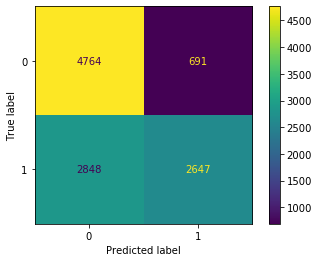

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

binary_prediction = [1 if i>0.5 else 0 for i in predictions.reshape(-1)]
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label, binary_prediction)).plot()

In [32]:
print(classification_report(test_label, binary_prediction))

              precision    recall  f1-score   support

           0       0.63      0.87      0.73      5455
           1       0.79      0.48      0.60      5495

    accuracy                           0.68     10950
   macro avg       0.71      0.68      0.66     10950
weighted avg       0.71      0.68      0.66     10950



In [33]:
from sklearn.linear_model import LogisticRegression

In [41]:
train_df, test_df, train_df_label, test_df_label = train_test_split(working_df, label, test_size = 0.2)
train_df, val_df, train_df_label, val_df_label = train_test_split(train_df, train_df_label, test_size = 0.2)

In [49]:
regressor = LogisticRegression()
regressor.fit(train_df, train_label)

LogisticRegression()

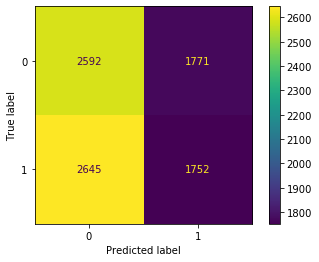

In [52]:
regressor_predictions =regressor.predict(val_df)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(val_df_label, regressor_predictions)).plot()

In [53]:
print(classification_report(val_df_label, regressor_predictions))

              precision    recall  f1-score   support

           0       0.49      0.59      0.54      4363
           1       0.50      0.40      0.44      4397

    accuracy                           0.50      8760
   macro avg       0.50      0.50      0.49      8760
weighted avg       0.50      0.50      0.49      8760



In [54]:
working_df

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
155070,23.49,0,0,0,2.0,0.0,0,0,0,0,0,0,0,7.0,0,0,0
187033,27.41,1,0,0,0.0,0.0,0,1,1,0,0,0,1,8.0,0,1,1
215564,25.40,0,0,0,0.0,0.0,0,1,2,0,0,0,1,6.0,0,1,1
131421,36.59,1,0,0,1.0,0.0,0,1,0,0,0,0,1,8.0,0,1,1
17854,28.89,1,0,1,30.0,30.0,1,0,1,1,0,1,2,6.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275768,31.46,0,0,0,0.0,10.0,0,1,1,0,1,1,0,8.0,0,1,1
68242,29.99,0,1,0,0.0,2.0,0,1,3,0,0,0,4,7.0,0,1,0
277990,26.57,1,0,0,14.0,0.0,0,0,0,0,0,0,3,6.0,0,1,0
197216,29.84,0,0,1,1.0,0.0,0,1,4,2,0,0,4,10.0,0,1,0
